In [1]:
import math
import pandas_datareader as pdr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [2]:
#API Key
key="8b207819bef44aa810ebe8f3221ec57c78328488"

In [3]:
#Class to get stock info
class stockdata:
    def __init__(stock, ticker):
        stock.df = pdr.get_data_tiingo(ticker, api_key=key)
        stock.df.to_csv(ticker+'.csv')
        stock.df=pd.read_csv(ticker+'.csv')

In [4]:
#Example stock
AU = stockdata("AU")
AU.df.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas_datareader\tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  return pd.concat(dfs, self._concat_axis)


,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AU,2017-12-05 00:00:00+00:00,9.75,9.80,9.5800,9.60,3992625,9.111383,9.158108,8.952518,8.971208,3992625,0.0,1.0
1,AU,2017-12-06 00:00:00+00:00,9.14,9.44,9.1225,9.35,7155472,8.541337,8.821687,8.524983,8.737582,7155472,0.0,1.0
2,AU,2017-12-07 00:00:00+00:00,9.23,9.33,9.0800,9.10,3081762,8.625442,8.718892,8.485267,8.503957,3081762,0.0,1.0
3,AU,2017-12-08 00:00:00+00:00,9.16,9.23,9.1400,9.20,2813702,8.560027,8.625442,8.541337,8.597407,2813702,0.0,1.0
4,AU,2017-12-11 00:00:00+00:00,9.09,9.39,9.0300,9.28,2514124,8.494612,8.774962,8.438542,8.672167,2514124,0.0,1.0


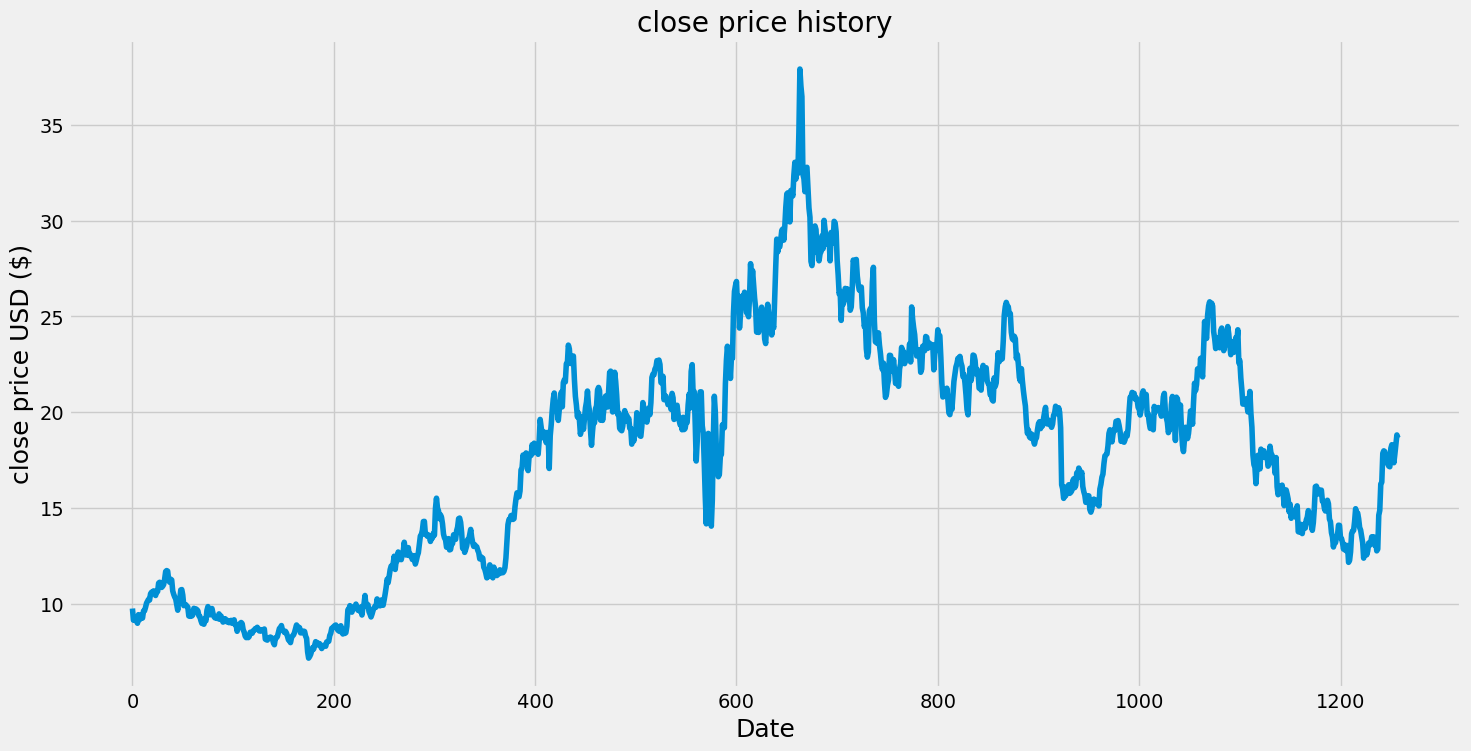

In [5]:
plt.figure(figsize=(16,8))
plt.title('close price history')
plt.plot(AU.df['close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('close price USD ($)', fontsize=18)
plt.show()

In [6]:
import numpy
#Convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [7]:
#Preparing data for ML
##Create a dataframe with only the close column
AU_df = AU.df.reset_index()['close']
##Convert to numpy array and transform values between 0  and 1
scaler = MinMaxScaler(feature_range=(0,1))
AU_df = scaler.fit_transform(np.array(AU_df).reshape(-1,1))
AU_df

array([[0.08422764],
       [0.06439024],
       [0.06731707],
       ...,
       [0.36325203],
       [0.37886179],
       [0.37398374]])

In [8]:
#Creating the training data set
##Splitting the data set into both train and test sets
AU_training_size=int(len(AU_df)*0.60)
AU_test_size=len(AU_df)-AU_training_size
AU_train_data, AU_test_data = AU_df[0:AU_training_size,:],AU_df[AU_training_size:len(AU_df),:1]
AU_training_size, AU_test_size

(754, 504)

In [9]:
#Reshaping data
AU_time_step = 100
AU_X_train, AU_y_train = create_dataset(AU_train_data, AU_time_step)
AU_X_test, AU_y_test = create_dataset(AU_test_data, AU_time_step)

In [10]:
print(AU_X_train.shape), print(AU_y_train.shape)
print(AU_X_test.shape), print(AU_y_test.shape)

(653, 100)
(653,)
(403, 100)
(403,)


(None, None)

In [11]:
#reshape input for LTSM
AU_X_train = AU_X_train.reshape(AU_X_train.shape[0], AU_X_train.shape[1], 1)
AU_X_test = AU_X_test.reshape(AU_X_test.shape[0], AU_X_test.shape[1], 1)

In [12]:
#Create the stacked LTSM model
model=Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100,1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))          
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer = "adam")
model.summary()         
 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [13]:
AU_train_predict=model.predict(AU_X_train)
AU_test_predict=model.predict(AU_X_test)

13/13 [==============================] - 1s 66ms/step


In [18]:
#Get the models predicted price values
##transform back to original form
AU_train_predict = scaler.inverse_transform(AU_train_predict)
AU_test_predict = scaler.inverse_transform(AU_test_predict)


In [19]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(AU_y_train, AU_train_predict))


234.32894898640862

In [20]:
### Test data RMSE
math.sqrt(mean_squared_error(AU_y_test, AU_test_predict))

235.03814018353273

In [23]:
day_new=np.arange(1,101)
day_pred=np.arange(101,111)
len(AU_df)

1258

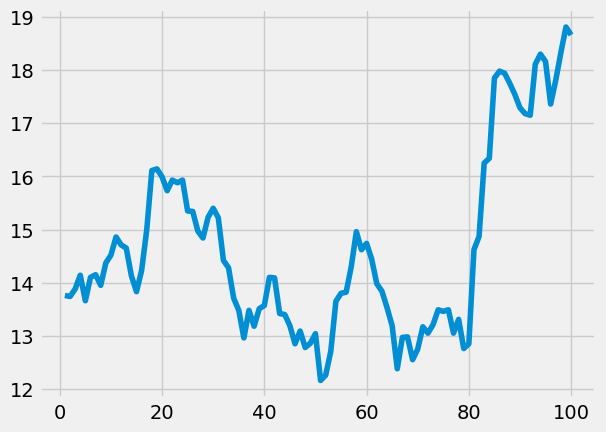

In [24]:
plt.plot(day_new, scaler.inverse_transform(AU_df[1158:]))
